In [1]:
pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
100% 1.97G/1.98G [00:19<00:00, 126MB/s]
100% 1.98G/1.98G [00:19<00:00, 108MB/s]


In [6]:
!unzip fruit-and-vegetable-image-recognition.zip

Archive:  fruit-and-vegetable-image-recognition.zip
  inflating: test/apple/Image_1.jpg  
  inflating: test/apple/Image_10.jpg  
  inflating: test/apple/Image_2.jpg  
  inflating: test/apple/Image_3.jpg  
  inflating: test/apple/Image_4.jpg  
  inflating: test/apple/Image_5.jpg  
  inflating: test/apple/Image_6.JPG  
  inflating: test/apple/Image_7.jpg  
  inflating: test/apple/Image_8.jpg  
  inflating: test/apple/Image_9.jpg  
  inflating: test/banana/Image_1.jpg  
  inflating: test/banana/Image_10.jpg  
  inflating: test/banana/Image_2.jpg  
  inflating: test/banana/Image_3.jpg  
  inflating: test/banana/Image_4.jpg  
  inflating: test/banana/Image_5.jpg  
  inflating: test/banana/Image_6.jpg  
  inflating: test/banana/Image_8.jpg  
  inflating: test/banana/Image_9.jpg  
  inflating: test/beetroot/Image_1.jpg  
  inflating: test/beetroot/Image_10.jpg  
  inflating: test/beetroot/Image_2.jpg  
  inflating: test/beetroot/Image_3.jpg  
  inflating: test/beetroot/Image_4.jpg  
  inflati

In [39]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
train_dir = '/content/train'
validation_dir = '/content/validation'
test_dir = '/content/test'

In [14]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(f'number of classes in {folder_name} folder : {len(classes)}')

num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 36
number of classes in validation folder : 36
number of classes in test folder : 36


In [17]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

print(f'Number of samples in train : {len(train_df)}')
print(f'Number of samples in validation : {len(validation_df)}')
print(f'Number of samples test : {len(test_df)}')

Number of samples in train : 3115
Number of samples in validation : 351
Number of samples test : 359


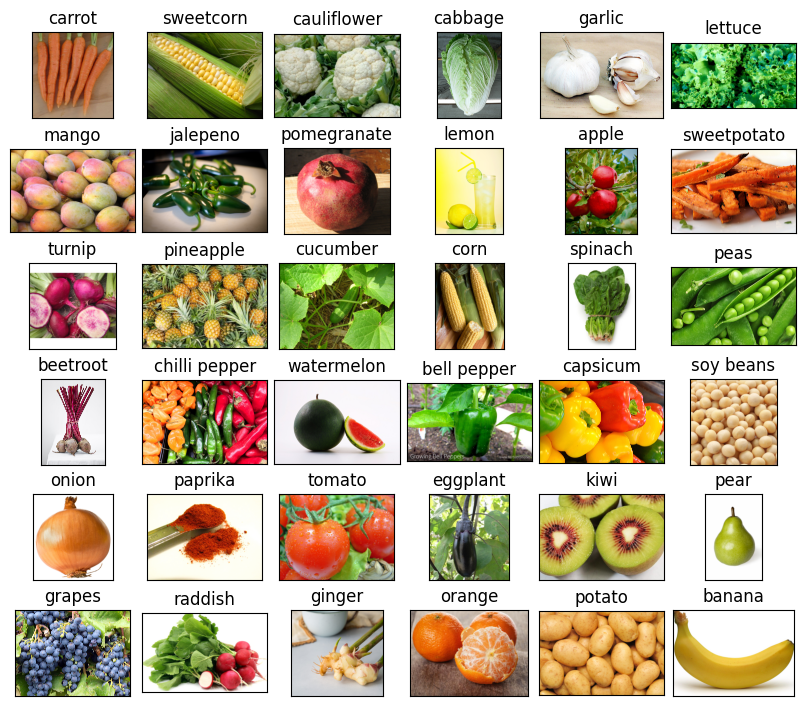

In [18]:
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [30]:
batch_size = 32
img_size = (299, 299)

train_dataset = image_dataset_from_directory(
    '/content/train',
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset = image_dataset_from_directory(
    '/content/validation',
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

test_dataset = image_dataset_from_directory(
    '/content/test',
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    batch_size=batch_size,
    image_size=img_size
)

class_names = train_dataset.class_names
print(class_names)

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Normalize datasets
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))


Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.
['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [32]:
model = InceptionV3(weights='imagenet', include_top = False, input_shape=(299, 299, 3))

model.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(36, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalization_94

In [33]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='mymodel.h5', save_best_only=True)
]

trained = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
98/98 [==============================] - ETA: 0s - loss: 1.5179 - accuracy: 0.5859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 141s 1s/step - loss: 1.5179 - accuracy: 0.5859 - val_loss: 0.5482 - val_accuracy: 0.8376
Epoch 2/30
98/98 [==============================] - 115s 1s/step - loss: 0.7724 - accuracy: 0.7528 - val_loss: 0.4298 - val_accuracy: 0.8661
Epoch 3/30
98/98 [==============================] - 115s 1s/step - loss: 0.6205 - accuracy: 0.7933 - val_loss: 0.3339 - val_accuracy: 0.9060
Epoch 4/30
98/98 [==============================] - 113s 1s/step - loss: 0.5651 - accuracy: 0.8042 - val_loss: 0.3347 - val_accuracy: 0.8946
Epoch 5/30
98/98 [==============================] - 113s 1s/step - loss: 0.5077 - accuracy: 0.8228 - val_loss: 0.3282 - val_accuracy: 0.8832
Epoch 6/30
98/98 [==============================] - 113s 1s/step - loss: 0.4304 - accuracy: 0.8411 - val_loss: 0.3245 - val_accuracy: 0.8775
Epoch 7/30
98/98 [==============================] - 114s 1s/step - loss: 0.3916 - accuracy: 0.8517 - val_loss: 0.2668 - val_accuracy: 0.9231
Epoch 8/30
98/98 [======

In [34]:
result_df = pd.DataFrame(trained.history)
result_df.tail()

,loss,accuracy,val_loss,val_accuracy
14,0.258536,0.904013,0.242434,0.920228
15,0.232664,0.914928,0.245084,0.920228
16,0.241782,0.909470,0.267132,0.917379
17,0.219726,0.922953,0.222867,0.934473
18,0.235230,0.913323,0.288218,0.925926


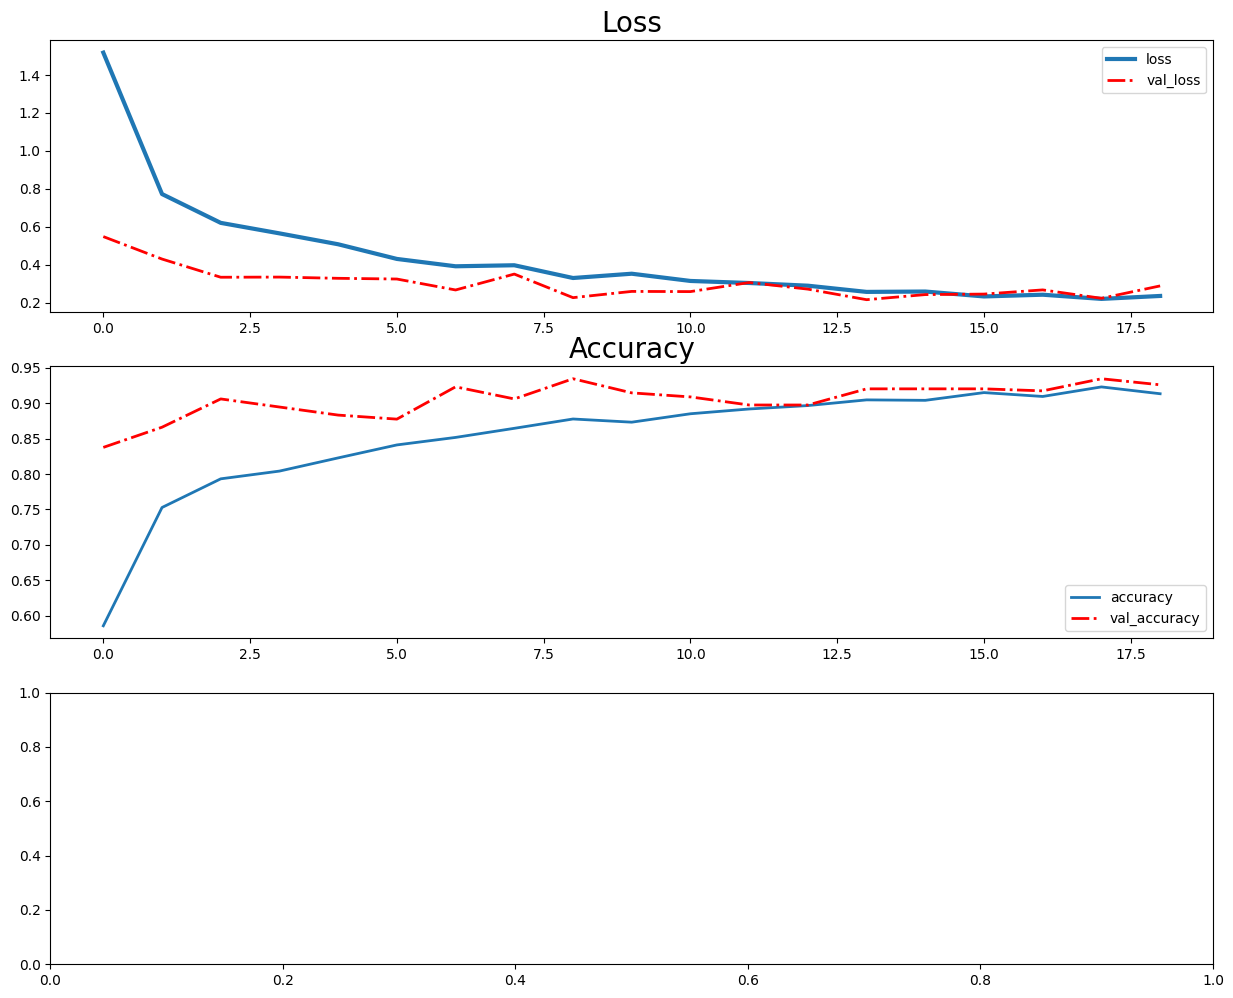

In [36]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

plt.sharex=True


plt.show()



In [43]:
best = tf.keras.models.load_model('/content/mymodel.h5')


test_loss, test_accuracy = best.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}')


12/12 [==============================] - 11s 694ms/step - loss: 0.2250 - accuracy: 0.9164
Test accuracy: 0.9164345264434814


In [45]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [70]:
# Function to load and preprocess image
def load_and_preprocess_image(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def predict_image(model, img_path, img_size, class_names):
    img_array = load_and_preprocess_image(img_path, img_size)
    predictions = model.predict(img_array)
    top_3_indices = np.argsort(predictions[0])[-3:][::-1]
    top_3_classes = [class_names[i] for i in top_3_indices]
    top_3_probs = [predictions[0][i] for i in top_3_indices]
    return top_3_classes, top_3_probs

# Example usage for prediction
img_path = '/content/carrots.jpg'  # Replace with your image path
top_3_classes, top_3_probs = predict_image(best, img_path, img_size, class_names)
print(f'Top 3 predicted classes: {top_3_classes}')
print(f'Top 3 prediction probabilities: {top_3_probs}')

1/1 [==============================] - 0s 46ms/step
Top 3 predicted classes: ['carrot', 'raddish', 'sweetpotato']
Top 3 prediction probabilities: [0.99060094, 0.0048831007, 0.0025207233]


In [72]:
tf.saved_model.save(best, "/content/model")

In [75]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/model")
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)